# Deep inside: Autoencoders

1. Vanilla autoencoders
2. Multilayer autoencoder


## Import the libraries

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

Using TensorFlow backend.


## Load the data

We don't need the labels as the autoencoders are unsupervised network

In [43]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

## Normalize the data

We want the pixels values between 0 and 1 instead of between 0 and 255

In [44]:
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


## Flatten the images for the Fully-Connected Networks

In [45]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
X_train.shape

(60000, 784)

___

# **Vanilla Autoencoder**

### Create the network

The first network is the most simple autoencoder. It has three layers : Input - encoded - decoded

In [46]:
input_size = 784
hidden_size = 64
output_size = 784

In [47]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

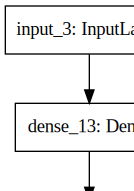

In [48]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

### Train

In [49]:
epochs = 50
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.0443 - val_loss: 0.0224
Epoch 2/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0173 - val_loss: 0.0129
Epoch 3/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0109 - val_loss: 0.0087
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0077 - val_loss: 0.0066
Epoch 5/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0061 - val_loss: 0.0055
Epoch 6/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0053 - val_loss: 0.0049
Epoch 7/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0049 - val_loss: 0.0045
Epoch 8/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0046 - val_loss: 0.0043
Epoch 9/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0044 - val_loss: 0.0042
Epoch

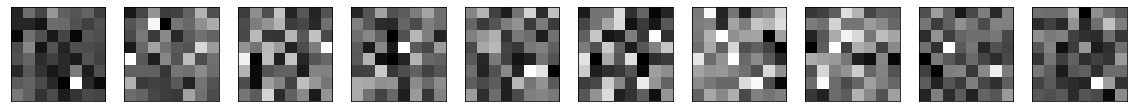

In [50]:
conv_encoder = Model(x, h)
encoded_imgs = conv_encoder.predict(X_test)
encoded_imgs_train = conv_encoder.predict(X_train)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(8, 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Predict on the test set

In [51]:
decoded_imgs = autoencoder.predict(X_test)
decoded_imgs_train = autoencoder.predict(X_train)

### Plot

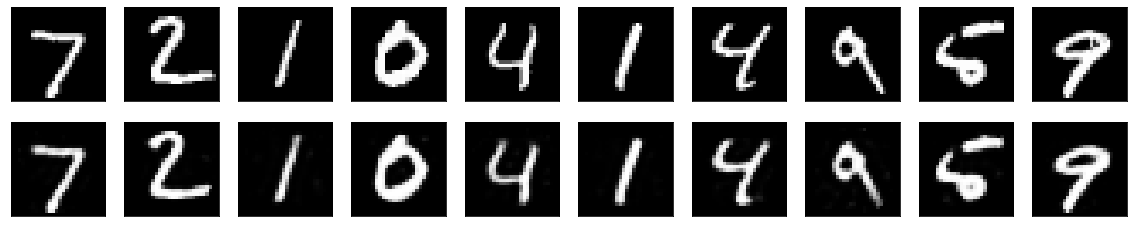

In [52]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

dict_keys(['val_loss', 'loss'])


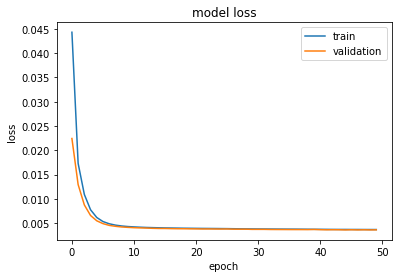

In [53]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Predicting

In [54]:
#one-hot encoding
from keras.models import Sequential

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


In [55]:
image_size = 784

model = Sequential()

model.add(Dense(units=32, activation='sigmoid', input_shape=(image_size,)))
model.add(Dense(units=10, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


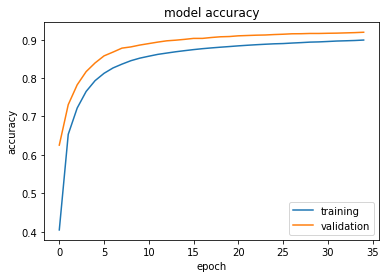

Test loss: 0.354
Test accuracy: 0.904


In [56]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=128, epochs=35, verbose=False, validation_split=.1)
loss, accuracy  = model.evaluate(X_test, y_test, verbose=False)
#print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

prediction: 2


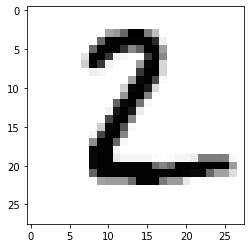

In [57]:
y_pred = model.predict(X_test)
plt.imshow(X_test[1].reshape(28, 28),cmap='Greys')
print(f'prediction: {y_pred[1].argmax()}')


In [58]:
model1 = Sequential()

model1.add(Dense(units=32, activation='sigmoid', input_shape=(image_size,)))
model1.add(Dense(units=10, activation='softmax'))
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


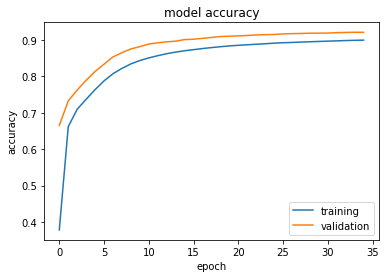

Test loss: 0.35
Test accuracy: 0.907


In [59]:
model1.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model1.fit(decoded_imgs_train, y_train, batch_size=128, epochs=35, verbose=False, validation_split=.1)
loss, accuracy  = model1.evaluate(decoded_imgs, y_test, verbose=False)
#print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [60]:
model_enc = Sequential()

model_enc.add(Dense(units=32, activation='sigmoid', input_shape=(64,)))
model_enc.add(Dense(units=10, activation='softmax'))
model_enc.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 10)                330       
Total params: 2,410
Trainable params: 2,410
Non-trainable params: 0
_________________________________________________________________


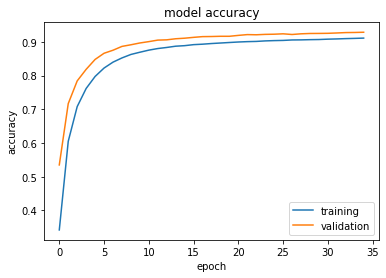

Test loss: 0.313
Test accuracy: 0.915


In [61]:
model_enc.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model_enc.fit(encoded_imgs_train, y_train, batch_size=128, epochs=35, verbose=False, validation_split=.1)
loss, accuracy  = model_enc.evaluate(encoded_imgs, y_test, verbose=False)
#print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [62]:
autoencoder.save_weights("autoencoder_wts.h5")

In [71]:
X_test.shape

(10000, 784)

In [64]:
np.save('intermediate_file', encoded_imgs)
np.save('intermediate_file_Train', encoded_imgs_train)
np.save('intermediate_file_Y', y_test)
np.save('intermediate_file_Y_Train', y_train)

In [102]:
def get_data(data):
    if data == "mnist":
        X_te = np.load('intermediate_file.npy')
        X_tr = np.load('intermediate_file_Train.npy')
        Y_te = np.load('intermediate_file_Y.npy')
        Y_tr = np.load('intermediate_file_Y_Train.npy')
        return (X_te, Y_te) , (X_tr, Y_tr)
    elif data == "mnist_multilayer":
        X_te = np.load('multi_intermediate_file.npy')
        X_tr = np.load('multi_intermediate_file_Train.npy')
        Y_te = np.load('intermediate_file_Y.npy')
        Y_tr = np.load('intermediate_file_Y_Train.npy')
        return (X_te, Y_te) , (X_tr, Y_tr)
    elif data == "mnist_convolusional":
        X_te = np.load('conv_intermediate_file.npy')
        X_tr = np.load('conv_intermediate_file_Train.npy')
        Y_te = np.load('intermediate_file_Y.npy')
        Y_tr = np.load('intermediate_file_Y_Train.npy')
        return (X_te, Y_te) , (X_tr, Y_tr)
    else:
        print("INVALID!!")

In [82]:
(enc_X_test, enc_Y_test), (enc_X_train, enc_Y_train) = get_data("mnist")
enc_X_test.shape

(10000, 64)

# **Multilayer autoencoder**

### Create the network

We extend the idea of the first network to more layers

In [72]:
input_size = 784
hidden_size = 128
code_size = 64

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(inputs=x, outputs=r)
encoder = Model(inputs=x, outputs=h)
autoencoder.compile(optimizer='adam', loss='mse')

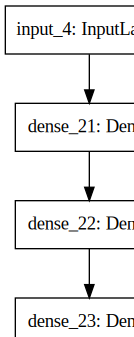

In [73]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

### Train the network

In [74]:
epochs = 50
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0413 - val_loss: 0.0194
Epoch 2/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.0164 - val_loss: 0.0134
Epoch 3/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0123 - val_loss: 0.0111
Epoch 4/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.0104 - val_loss: 0.0094
Epoch 5/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.0092 - val_loss: 0.0084
Epoch 6/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.0084 - val_loss: 0.0078
Epoch 7/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0077 - val_loss: 0.0072
Epoch 8/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.0071 - val_loss: 0.0067
Epoch 9/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0067 - val_loss: 0.0062
Epoch

### Predict on the test set

In [75]:
decoded_imgs = autoencoder.predict(X_test)
decoded_imgs_train = autoencoder.predict(X_train)

encoded_imgs = encoder.predict(X_test)
encoded_imgs_train = encoder.predict(X_train)

### Plot

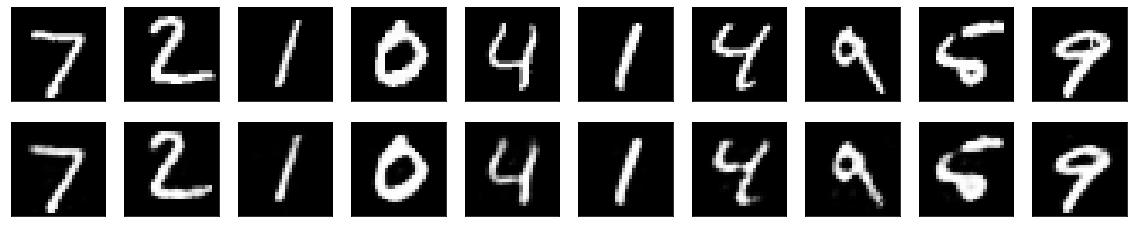

In [76]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

dict_keys(['val_loss', 'loss'])


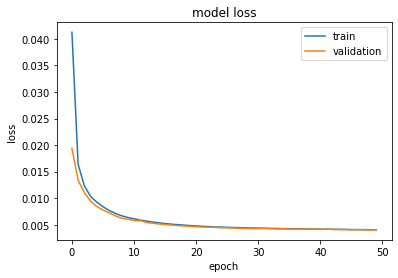

In [77]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

___

In [78]:
model_enc_mul = Sequential()

model_enc_mul.add(Dense(units=32, activation='sigmoid', input_shape=(64,)))
model_enc_mul.add(Dense(units=10, activation='softmax'))
model_enc_mul.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_26 (Dense)             (None, 10)                330       
Total params: 2,410
Trainable params: 2,410
Non-trainable params: 0
_________________________________________________________________


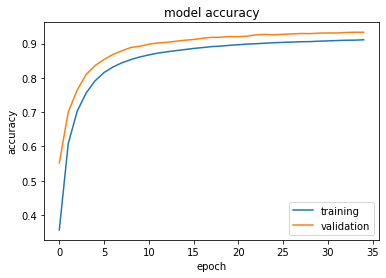

Test loss: 0.32
Test accuracy: 0.913


In [79]:
model_enc_mul.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model_enc_mul.fit(encoded_imgs_train, y_train, batch_size=128, epochs=35, verbose=False, validation_split=.1)
loss, accuracy  = model_enc_mul.evaluate(encoded_imgs, y_test, verbose=False)
#print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [80]:
np.save('multi_intermediate_file', encoded_imgs)
np.save('multi_intermediate_file_Train', encoded_imgs_train)

In [85]:
(enc_X_test, enc_Y_test), (enc_X_train, enc_Y_train) = get_data("mnist_multilayer")
enc_X_test.shape

(10000, 64)

# **Convolutional autoencoder**

In [86]:
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
y_train[1]

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Create the network

This network does not take flattened vectors as an input but images

In [87]:
x = Input(shape=(28, 28,1)) 

# Encoder
conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
h = MaxPooling2D((2, 2), padding='same')(conv1_3)


# Decoder
conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
conv2_3 = Conv2D(16, (3, 3), activation='relu')(up2)
up3 = UpSampling2D((2, 2))(conv2_3)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(inputs=x, outputs=r)
Encoder = Model(x,h)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

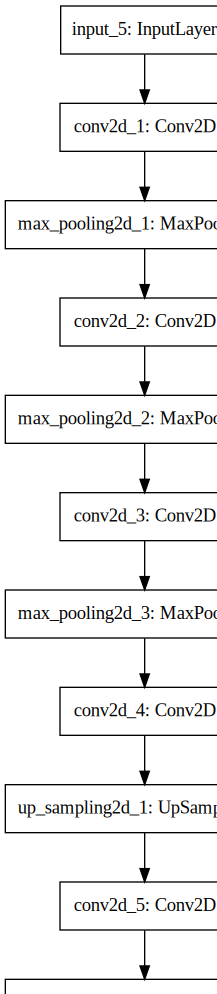

In [88]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

### Train

In [89]:
epochs = 15
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 61s 1ms/step - loss: 0.2094 - val_loss: 0.1640
Epoch 2/15
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1521 - val_loss: 0.1449
Epoch 3/15
60000/60000 [==============================] - 63s 1ms/step - loss: 0.1381 - val_loss: 0.1306
Epoch 4/15
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1301 - val_loss: 0.1262
Epoch 5/15
60000/60000 [==============================] - 62s 1ms/step - loss: 0.1251 - val_loss: 0.1179
Epoch 6/15
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1218 - val_loss: 0.1206
Epoch 7/15
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1192 - val_loss: 0.1158
Epoch 8/15
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1173 - val_loss: 0.1161
Epoch 9/15
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1157 - val_loss: 0.1108
Epoch

In [90]:
decoded_imgs = autoencoder.predict(X_test)
decoded_imgs_train = autoencoder.predict(X_train)

encoded_imgs = Encoder.predict(X_test)
encoded_imgs_train = Encoder.predict(X_train)

encoded_imgs_train = encoded_imgs_train.reshape((len(encoded_imgs_train), np.prod(encoded_imgs_train.shape[1:])))
encoded_imgs = encoded_imgs.reshape((len(encoded_imgs), np.prod(encoded_imgs.shape[1:])))

In [91]:
decoded_imgs_train = decoded_imgs_train.reshape((len(decoded_imgs_train), np.prod(decoded_imgs_train.shape[1:])))
decoded_imgs = decoded_imgs.reshape((len(decoded_imgs), np.prod(decoded_imgs.shape[1:])))

### Plot

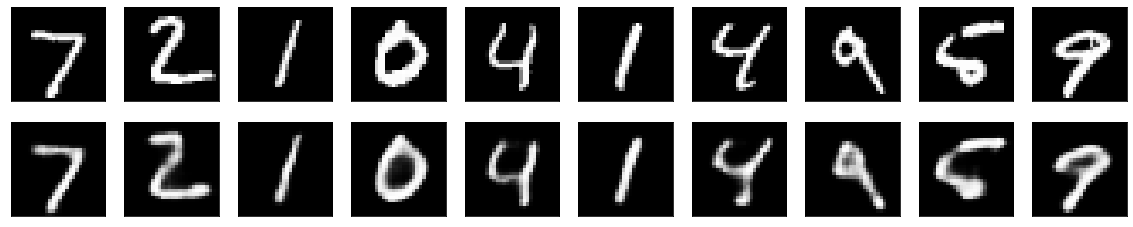

In [92]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plot the losses

dict_keys(['val_loss', 'loss'])


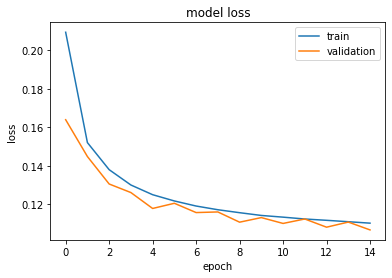

In [93]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

___

In [94]:
model_enc_conv = Sequential()

model_enc_conv.add(Dense(units=32, activation='sigmoid', input_shape=(128,)))
model_enc_conv.add(Dense(units=10, activation='softmax'))
model_enc_conv.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_28 (Dense)             (None, 10)                330       
Total params: 4,458
Trainable params: 4,458
Non-trainable params: 0
_________________________________________________________________


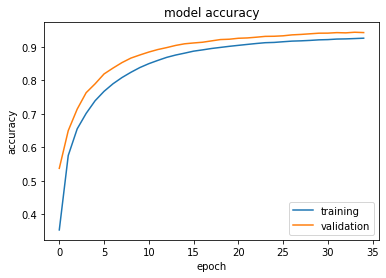

Test loss: 0.27
Test accuracy: 0.931


In [95]:
model_enc_conv.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model_enc_conv.fit(encoded_imgs_train, y_train, batch_size=128, epochs=35, verbose=False, validation_split=.1)
loss, accuracy  = model_enc_conv.evaluate(encoded_imgs, y_test, verbose=False)
#print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

In [105]:
autoencoder.save_weights("conv_autoencoder_wts.h5")

In [103]:
np.save('conv_intermediate_file', encoded_imgs)
np.save('conv_intermediate_file_Train', encoded_imgs_train)

In [104]:
(enc_X_test, enc_Y_test), (enc_X_train, enc_Y_train) = get_data("mnist_convolusional")
enc_X_test.shape

(10000, 128)

# Predicting with encoded data

In [108]:
(enc_X_test, enc_Y_test), (enc_X_train, enc_Y_train) = get_data("mnist")
enc_X_test.shape

(10000, 64)

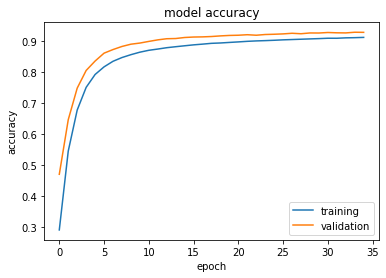

Test loss: 0.316
Test accuracy: 0.918


In [109]:
model_test = Sequential()

model_test.add(Dense(units=32, activation='sigmoid', input_shape=(64,)))
model_test.add(Dense(units=10, activation='softmax'))

model_test.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model_test.fit(enc_X_train, enc_Y_train, batch_size=128, epochs=35, verbose=False, validation_split=.1)
loss, accuracy  = model_test.evaluate(enc_X_test, enc_Y_test, verbose=False)
#print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')